In [1]:
!pip install SPARQLWrapper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from SPARQLWrapper import SPARQLWrapper

In [3]:
def execute_sparql_query(endpoint, query):
    # Initialize SPARQLWrapper with the endpoint
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    # Execute the query and retrieve the results
    results = sparql.query().convert()
    bindings = results["results"]["bindings"]

    # Return an empty DataFrame if there are no results
    if not bindings:
        return pd.DataFrame()

    # Extract column names from the first result entry
    columns = bindings[0].keys()

    # Convert results to a list of dictionaries
    data = []
    for row in bindings:
        data.append({col: row[col]['value'] for col in columns})

    # Convert list of dictionaries to a Pandas DataFrame
    return pd.DataFrame(data)

In [40]:
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt

# Define the SPARQL endpoint (ChEmBL)
SPARQL_ENDPOINT = "https://chemblmirror.rdf.bigcat-bioinformatics.org/sparql"

# Set the SPARQL query
SPARQL_QUERY_1 = """
PREFIX chembl: <http://rdf.ebi.ac.uk/terms/chembl#>
PREFIX cco: <http://rdf.ebi.ac.uk/terms/chembl#>
PREFIX chembl_molecule: <http://rdf.ebi.ac.uk/resource/chembl/molecule/>
PREFIX chembl_target: <http://rdf.ebi.ac.uk/resource/chembl/target/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?assayLabel ?assayType ?molLabel ?molID ?bindingAffinityType ?value WHERE {

  ?assay  chembl:hasTarget chembl_target:CHEMBL5514.

  ?activity chembl:hasAssay  ?assay.
  ?assay cco:assayType ?assayType.
  ?activity chembl:hasMolecule ?molecule.

  chembl_target:CHEMBL204 rdfs:label ?targetLabel.
  ?molecule rdfs:label ?molLabel.
  ?molecule chembl:chemblId ?molID.  # Get molecule ID instead of broken image URLs

  ?assay  rdfs:label ?assayLabel.

  VALUES ?bindingAffinityType {"Kd" "Ki" "IC50"}
  ?activity chembl:type ?bindingAffinityType.
  ?activity chembl:standardValue ?value.

} LIMIT 100
"""

df = execute_sparql_query(SPARQL_ENDPOINT, SPARQL_QUERY_1)

In [41]:
df.head()

,assayLabel,assayType,molLabel,molID,bindingAffinityType,value
0,CHEMBL5129911,Binding,CHEMBL5195936,CHEMBL5195936,IC50,40.0
1,CHEMBL5129911,Binding,CHEMBL5175104,CHEMBL5175104,IC50,80.0
2,CHEMBL5129911,Binding,CHEMBL5179682,CHEMBL5179682,IC50,8.0
3,CHEMBL4714712,Binding,CHEMBL4761459,CHEMBL4761459,IC50,100.0
4,CHEMBL1029934,Binding,CHEMBL442675,CHEMBL442675,IC50,10000.0


In [6]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 51.0 MB/s eta 0:00:00


In [8]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Generate valid ChEMBL molecule image URLs
df["molImage"] = df["molID"].apply(lambda x: f"https://www.ebi.ac.uk/chembl/api/data/image/{x}.svg" if pd.notnull(x) else "")

# Function to fetch images
def fetch_image(url):
    try:
        response = requests.get(url, timeout=5)
        return Image.open(BytesIO(response.content))
    except:
        return None  # Return None if fetch fails

# Fetch images
df["image"] = df["molImage"].apply(fetch_image)

# Remove rows with missing images
valid_rows = df.dropna(subset=["image"]).reset_index()

# Check if images exist
num_images = len(valid_rows)
if num_images == 0:
    print("No valid images to display.")
else:
    grid_size = min(4, num_images)  # Max 4 columns
    num_rows = (num_images // grid_size) + (num_images % grid_size > 0)

    fig, axes = plt.subplots(num_rows, grid_size, figsize=(10, 10))
    axes = axes.flatten() if num_images > 1 else [axes]

    # Plot images
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(valid_rows["image"][i])
            ax.set_title(valid_rows["molLabel"][i])
            ax.axis("off")
        else:
            ax.axis("off")  # Hide empty subplots

    plt.tight_layout()
    plt.show()


No valid images to display.


In [21]:
print(df[["molID", "molLabel"]].head(10))

           molID       molLabel
0  CHEMBL5195936  CHEMBL5195936
1  CHEMBL5175104  CHEMBL5175104
2  CHEMBL5179682  CHEMBL5179682
3  CHEMBL4761459  CHEMBL4761459
4   CHEMBL442675   CHEMBL442675
5   CHEMBL449571   CHEMBL449571
6   CHEMBL495005   CHEMBL495005
7  CHEMBL4799079  CHEMBL4799079
8  CHEMBL4757451  CHEMBL4757451
9  CHEMBL4759534  CHEMBL4759534


In [22]:
for mol_id in df["molID"].dropna().head(5):
    print(f"https://www.ebi.ac.uk/chembl/api/data/image/{mol_id}.svg")

https://www.ebi.ac.uk/chembl/api/data/image/CHEMBL5195936.svg
https://www.ebi.ac.uk/chembl/api/data/image/CHEMBL5175104.svg
https://www.ebi.ac.uk/chembl/api/data/image/CHEMBL5179682.svg
https://www.ebi.ac.uk/chembl/api/data/image/CHEMBL4761459.svg
https://www.ebi.ac.uk/chembl/api/data/image/CHEMBL442675.svg


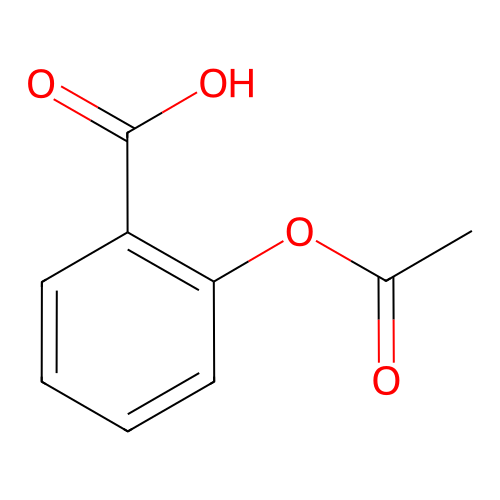

In [23]:
test_url = "https://www.ebi.ac.uk/chembl/api/data/image/CHEMBL25.svg"  # Replace with an actual molID from your data
response = requests.get(test_url, timeout=5)

if response.status_code == 200:
    from IPython.display import display, SVG
    display(SVG(response.content))  # Display SVG in Jupyter Notebook
else:
    print("Failed to fetch image:", response.status_code)

In [25]:
!pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.0 MB/s eta 0:00:00


In [26]:
from cairosvg import svg2png
from PIL import Image
from io import BytesIO
import requests

def fetch_and_convert_image(url):
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            png_data = svg2png(bytestring=response.content)
            return Image.open(BytesIO(png_data))
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None  # Return None if fetch fails

df["image"] = df["molImage"].apply(fetch_and_convert_image)

Molecule: CHEMBL5195936 (CHEMBL5195936)


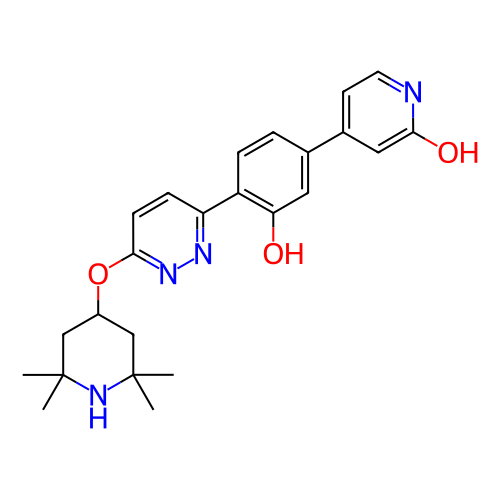

Molecule: CHEMBL5175104 (CHEMBL5175104)


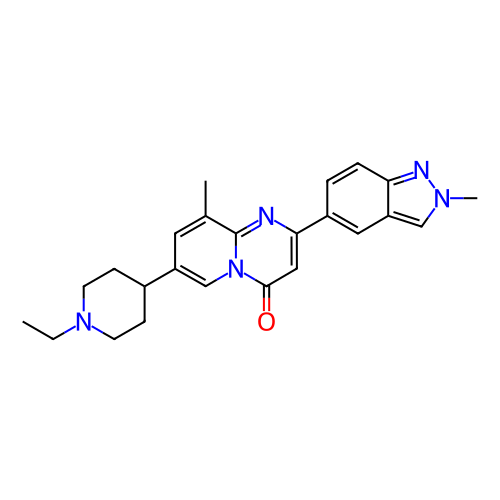

Molecule: CHEMBL5179682 (CHEMBL5179682)


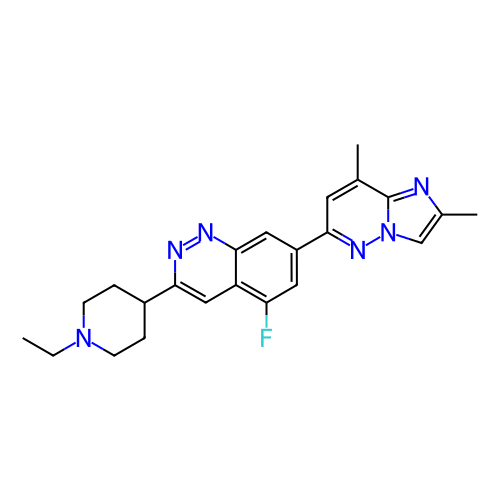

Molecule: CHEMBL4761459 (CHEMBL4761459)


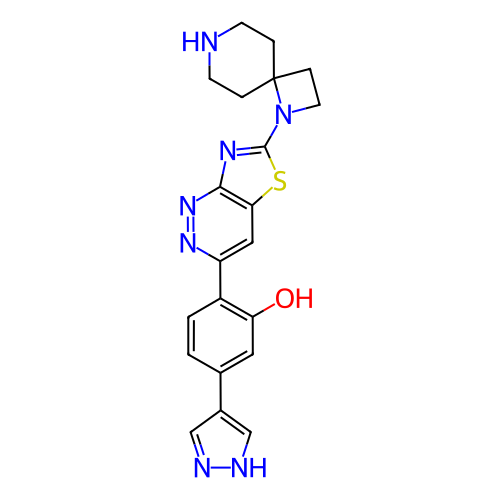

Molecule: CHEMBL442675 (CHEMBL442675)


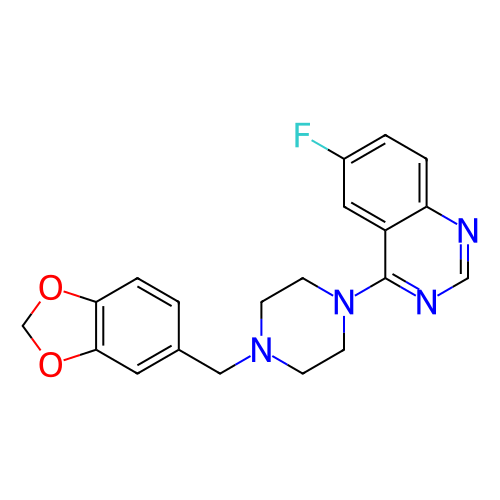

Molecule: CHEMBL449571 (CHEMBL449571)


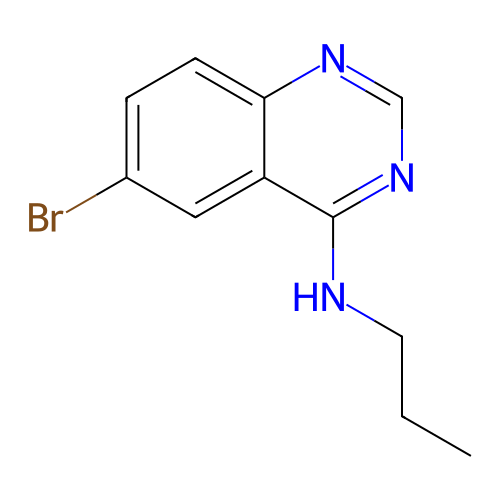

Molecule: CHEMBL495005 (CHEMBL495005)


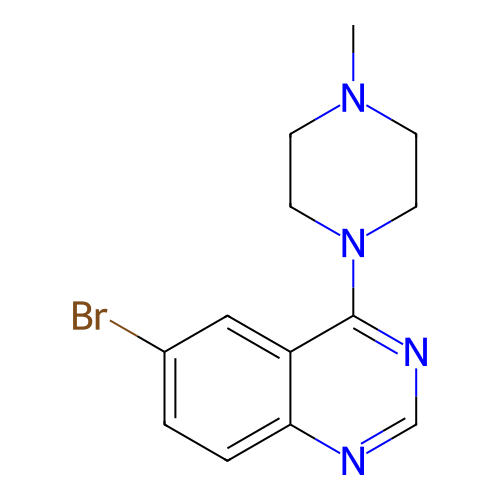

Molecule: CHEMBL4799079 (CHEMBL4799079)


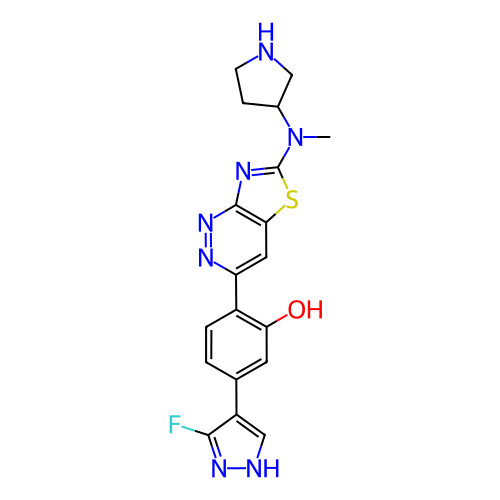

Molecule: CHEMBL4757451 (CHEMBL4757451)


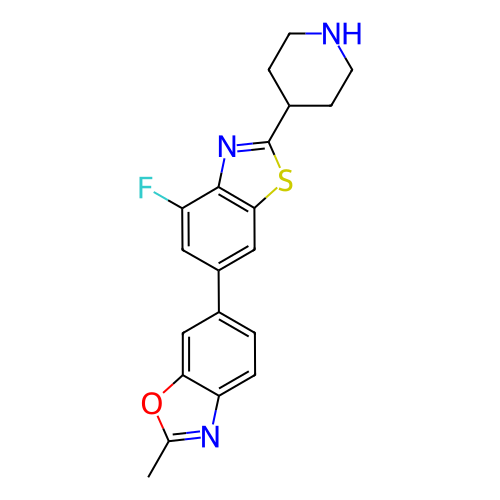

Molecule: CHEMBL4759534 (CHEMBL4759534)


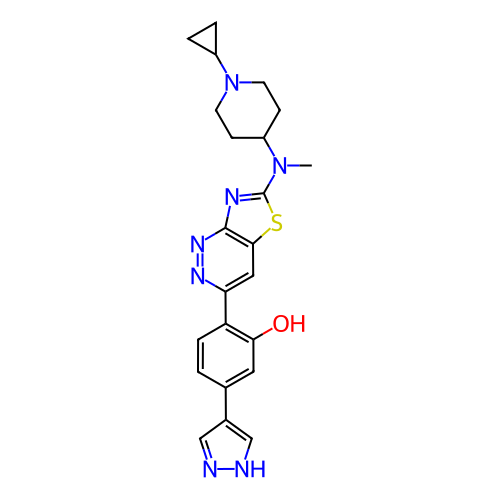

Molecule: CHEMBL4785183 (CHEMBL4785183)


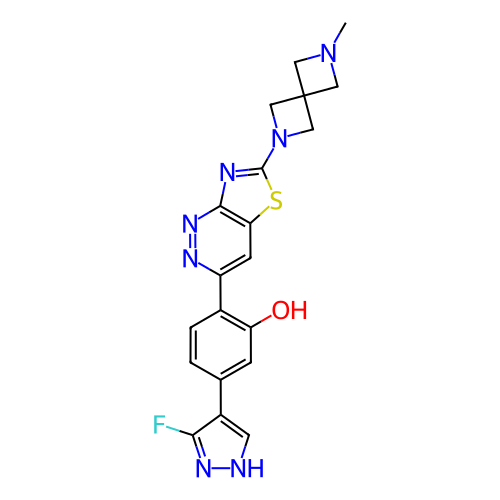

Molecule: CHEMBL4794728 (CHEMBL4794728)


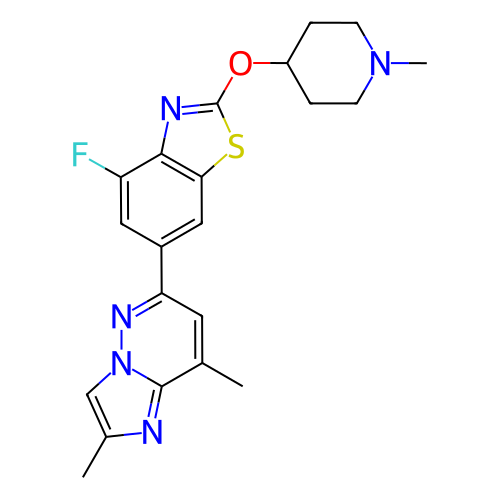

Molecule: CHEMBL4859053 (CHEMBL4859053)


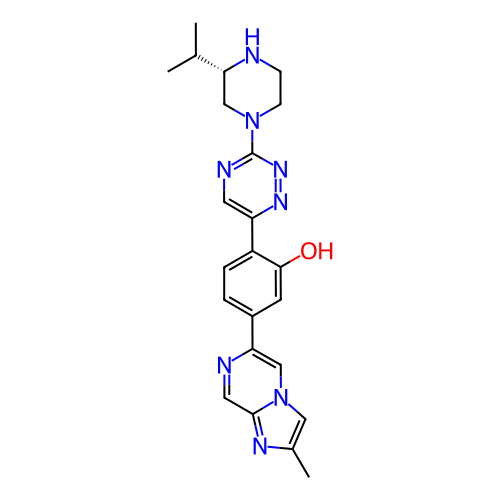

Molecule: CHEMBL4867927 (CHEMBL4867927)


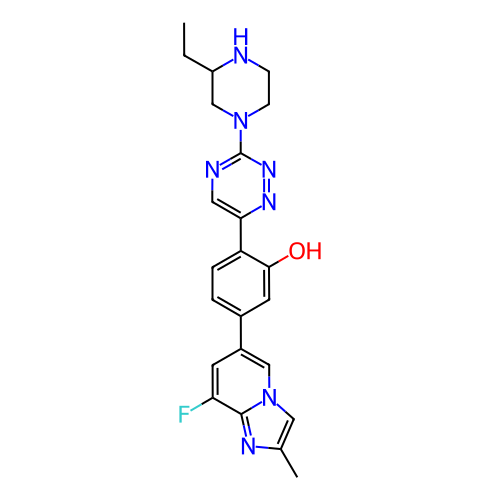

Molecule: CHEMBL4875017 (CHEMBL4875017)


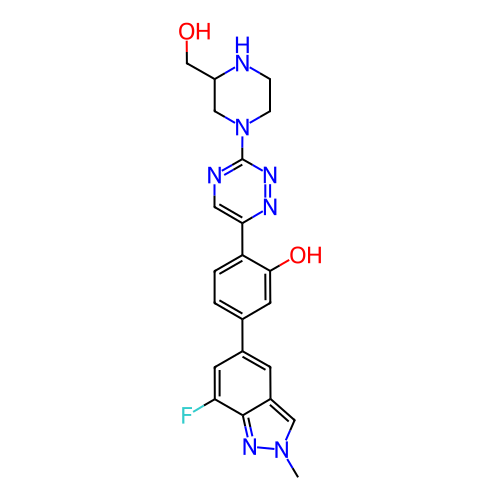

Molecule: CHEMBL4878942 (CHEMBL4878942)


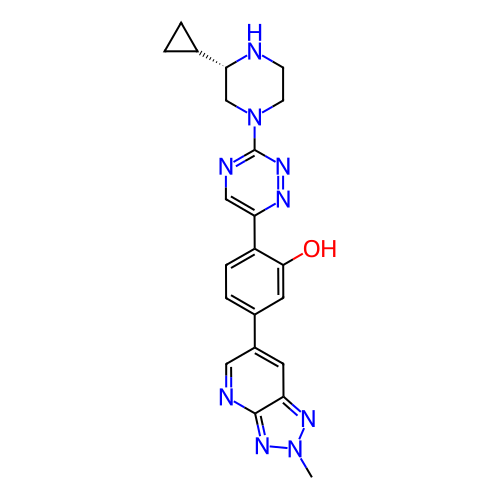

Molecule: CHEMBL4847156 (CHEMBL4847156)


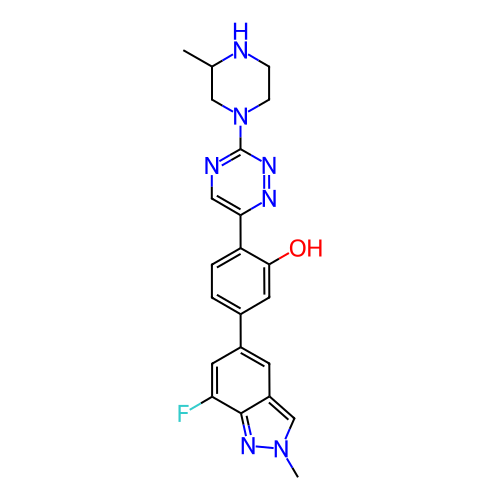

Molecule: CHEMBL4863336 (CHEMBL4863336)


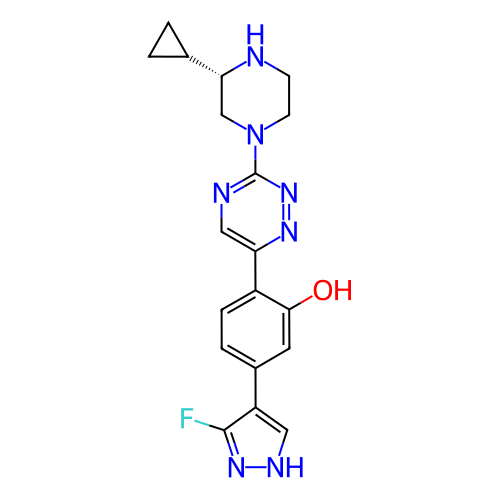

Molecule: CHEMBL149800 (CHEMBL149800)


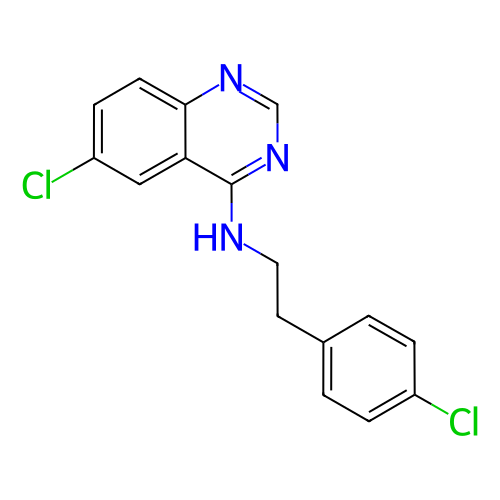

Molecule: CHEMBL494838 (CHEMBL494838)


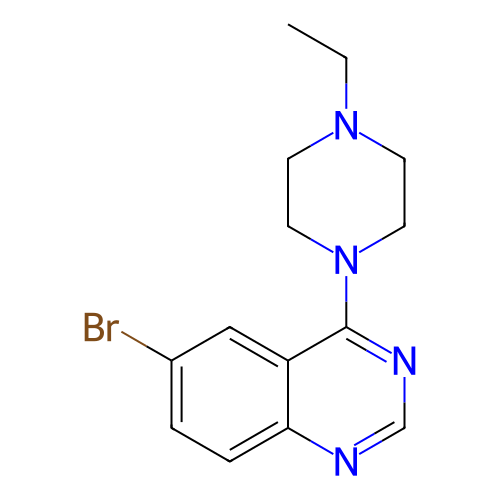

Molecule: CHEMBL4761220 (CHEMBL4761220)


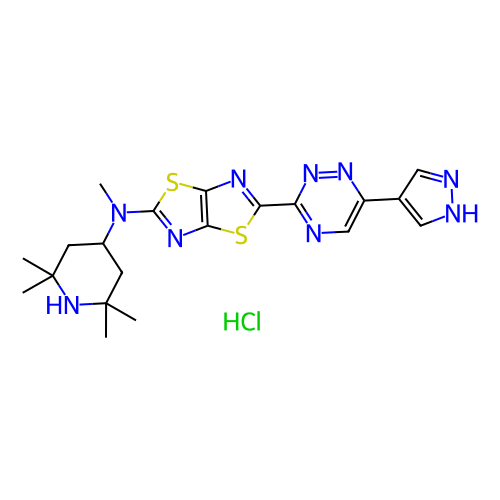

Molecule: CHEMBL4798090 (CHEMBL4798090)


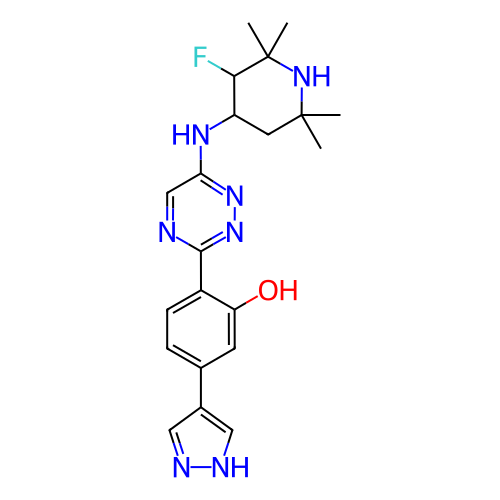

Molecule: CHEMBL4875396 (CHEMBL4875396)


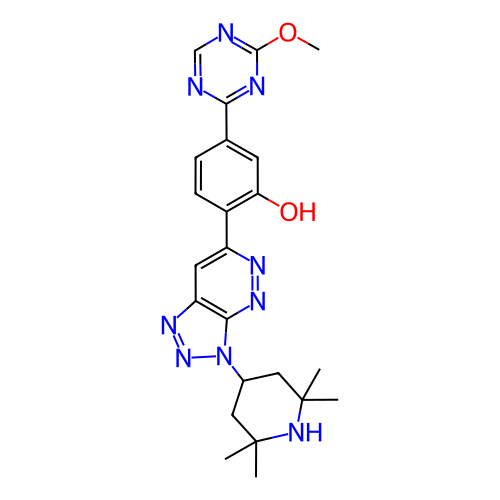

Molecule: CHEMBL153483 (CHEMBL153483)


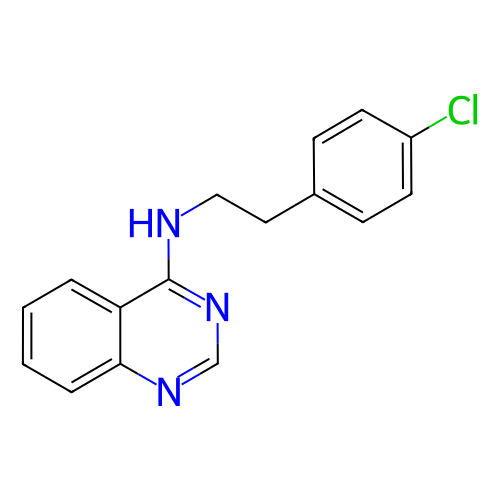

Molecule: CHEMBL4777225 (CHEMBL4777225)


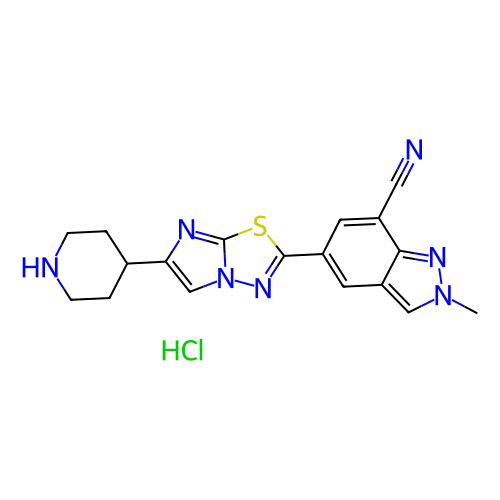

Molecule: CHEMBL4778330 (CHEMBL4778330)


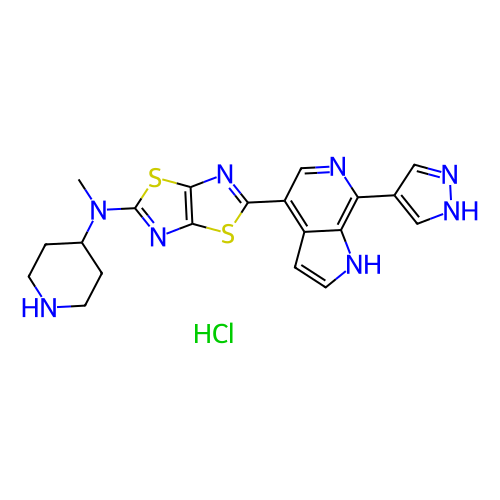

Molecule: CHEMBL4796814 (CHEMBL4796814)


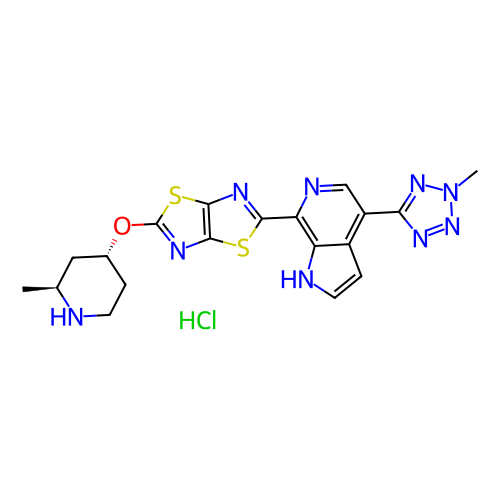

Molecule: CHEMBL4744003 (CHEMBL4744003)


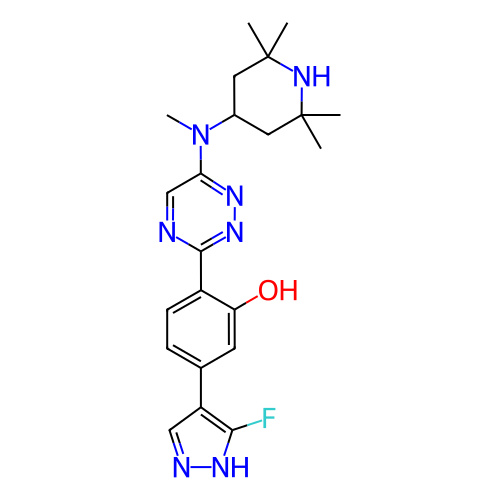

Molecule: CHEMBL4743319 (CHEMBL4743319)


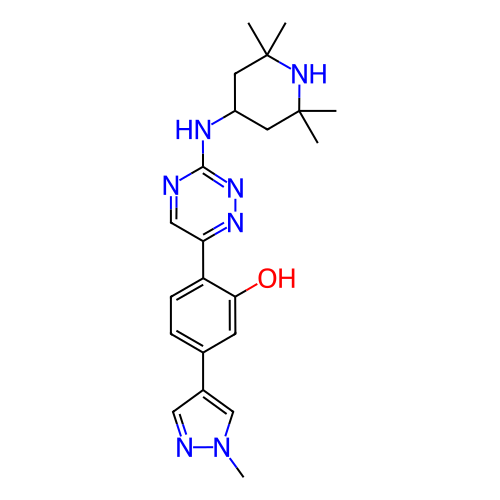

Molecule: CHEMBL4749870 (CHEMBL4749870)


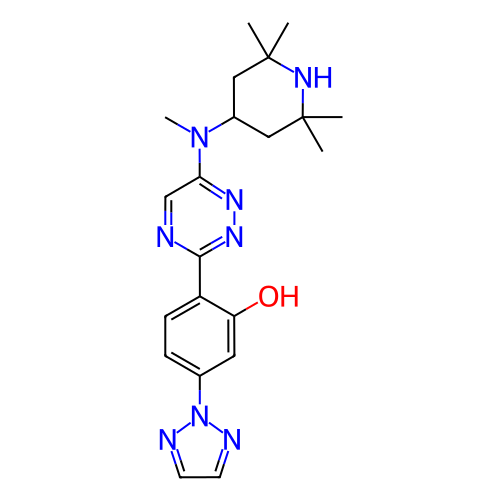

Molecule: CHEMBL4776322 (CHEMBL4776322)


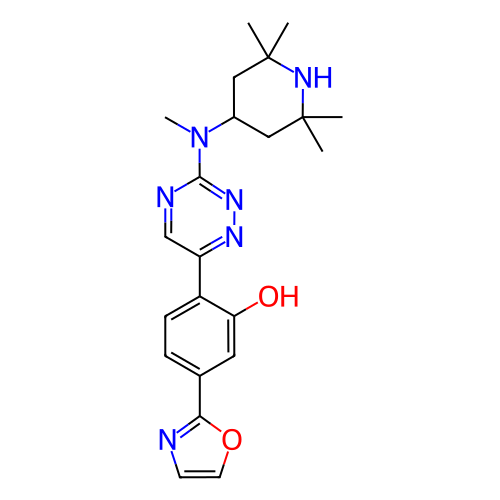

Molecule: CHEMBL493153 (CHEMBL493153)


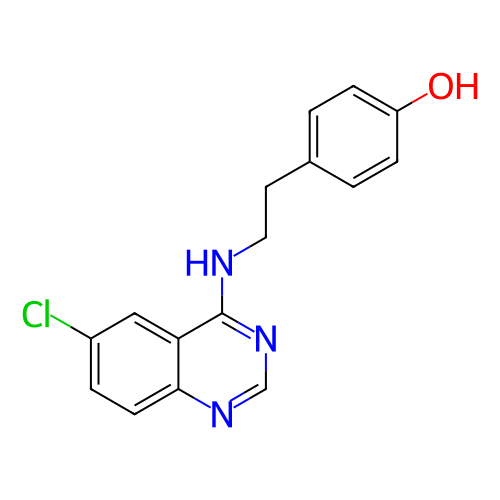

Molecule: CHEMBL444229 (CHEMBL444229)


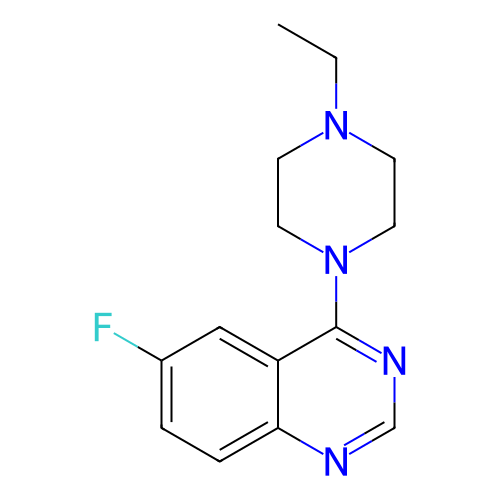

Molecule: CHEMBL445226 (CHEMBL445226)


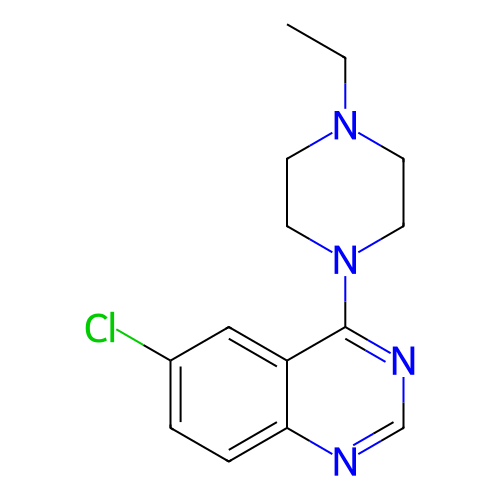

Molecule: CHEMBL451222 (CHEMBL451222)


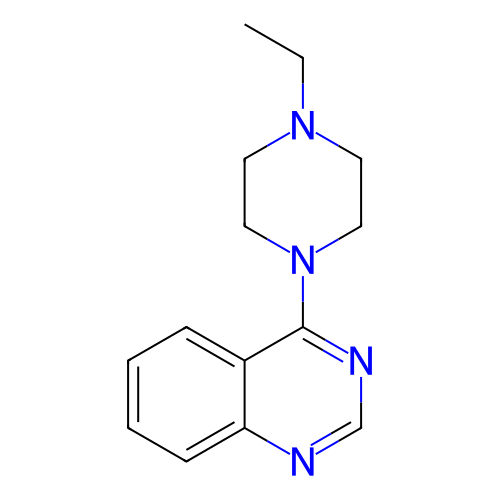

Molecule: CHEMBL489053 (CHEMBL489053)


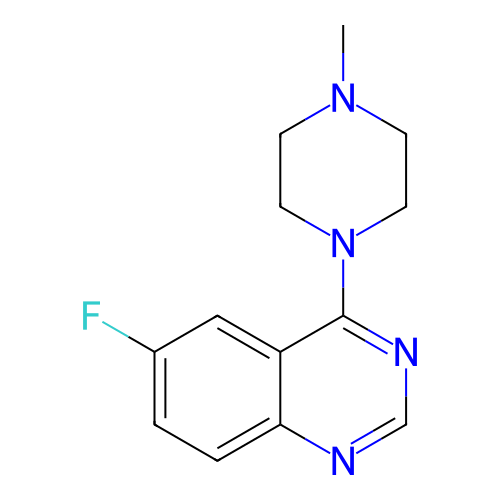

Molecule: CHEMBL493348 (CHEMBL493348)


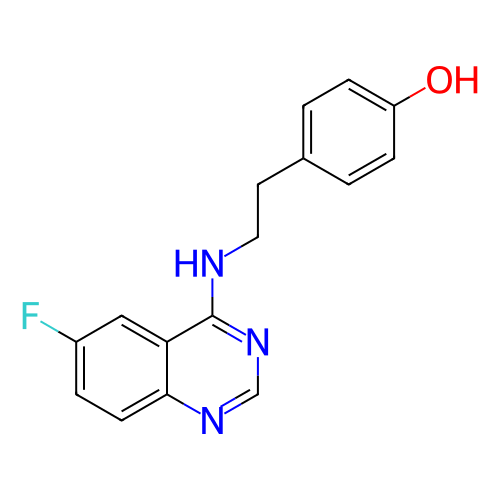

Molecule: CHEMBL493350 (CHEMBL493350)


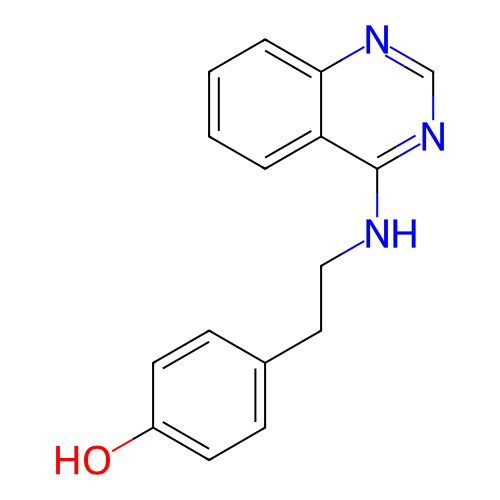

Molecule: CHEMBL494325 (CHEMBL494325)


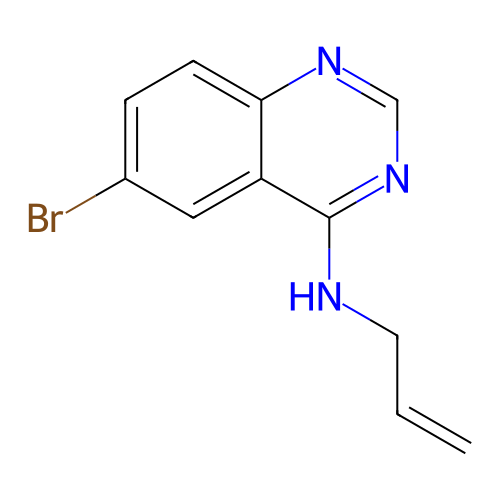

Molecule: CHEMBL494326 (CHEMBL494326)


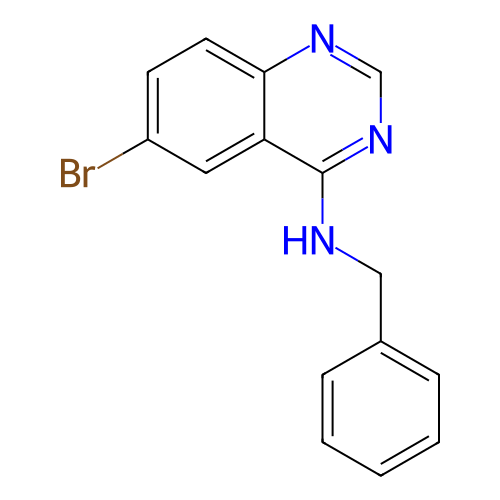

Molecule: CHEMBL500972 (CHEMBL500972)


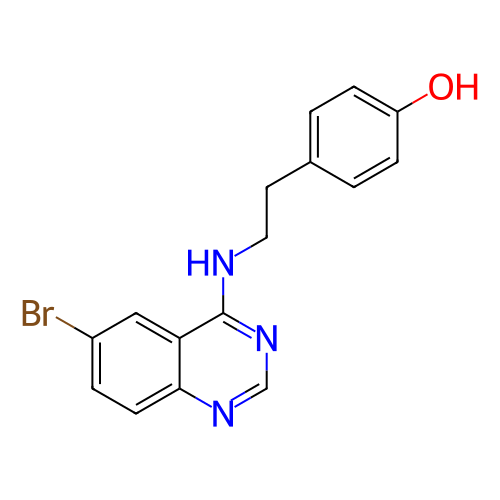

Molecule: CHEMBL506969 (CHEMBL506969)


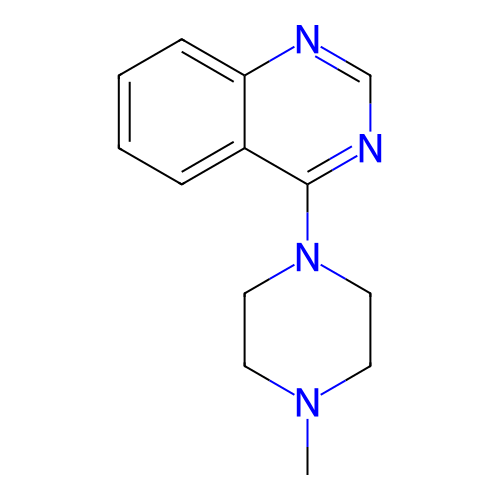

Molecule: CHEMBL509988 (CHEMBL509988)


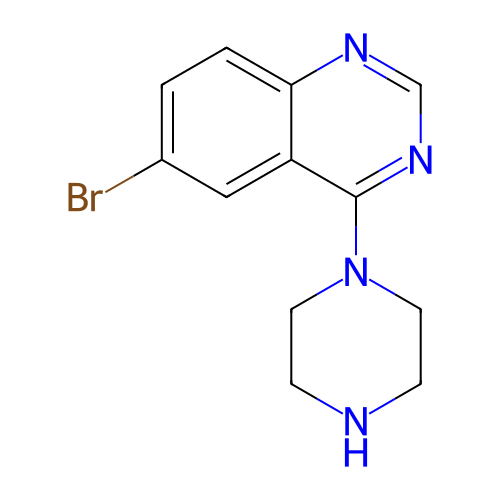

Molecule: CHEMBL2333942 (CHEMBL2333942)


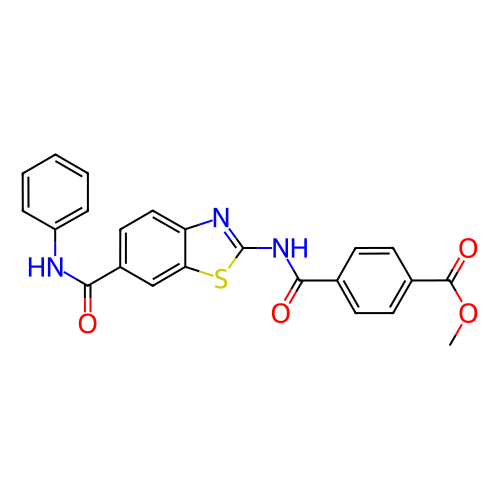

Molecule: CHEMBL493324 (CHEMBL493324)


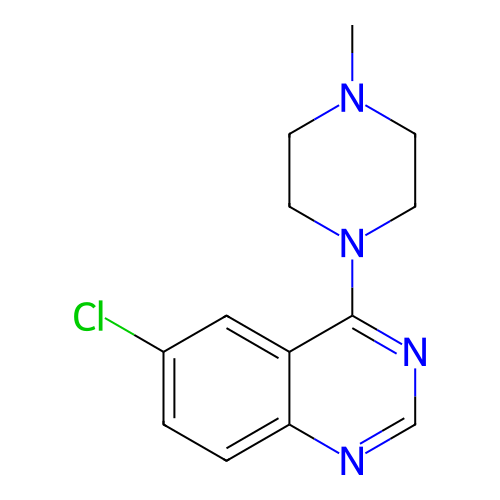

Molecule: CHEMBL493349 (CHEMBL493349)


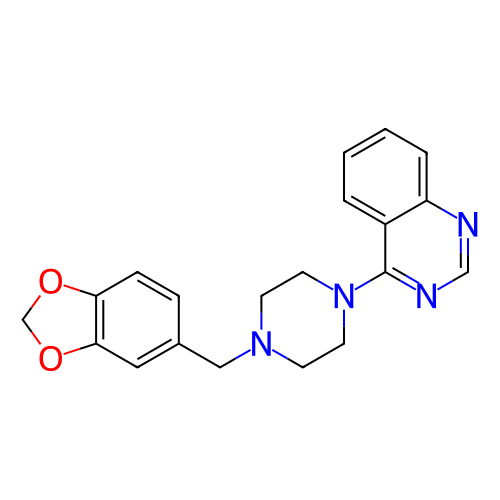

Molecule: CHEMBL4799758 (CHEMBL4799758)


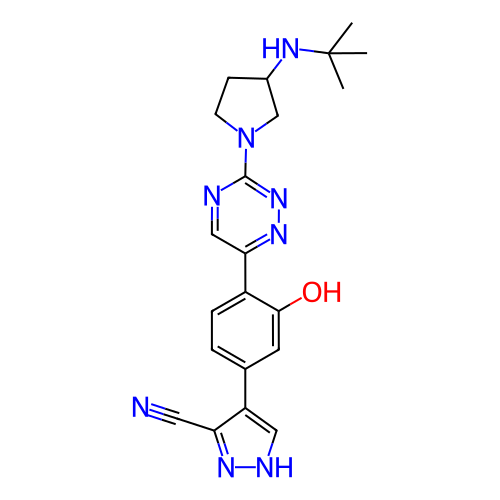

Molecule: CHEMBL493327 (CHEMBL493327)


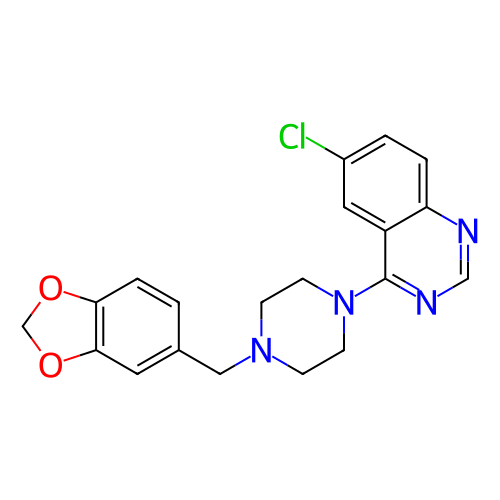

Molecule: CHEMBL494130 (CHEMBL494130)


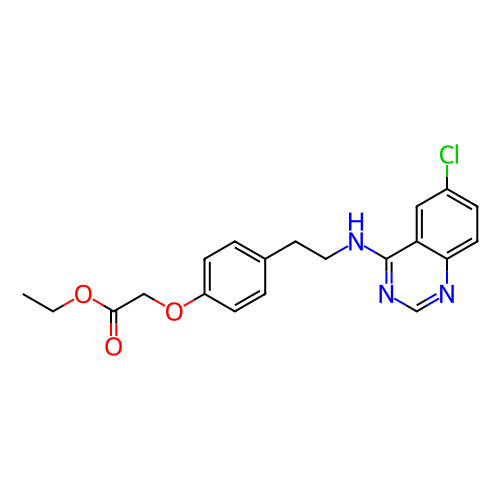

Molecule: CHEMBL4850295 (CHEMBL4850295)


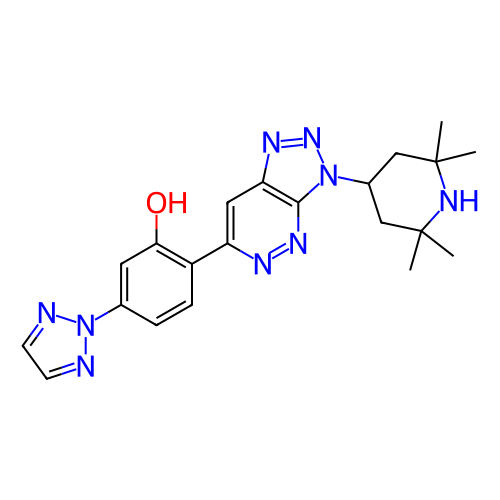

Molecule: CHEMBL4875823 (CHEMBL4875823)


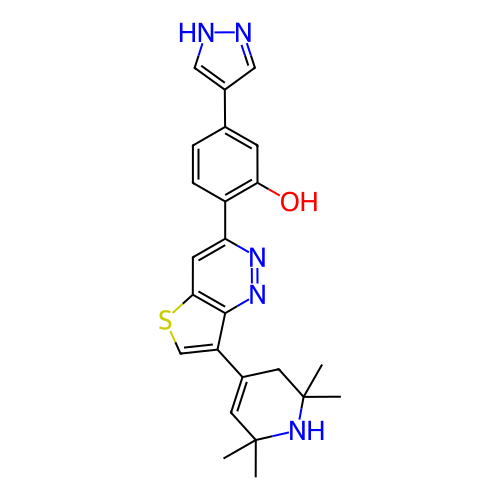

Molecule: CHEMBL4877649 (CHEMBL4877649)


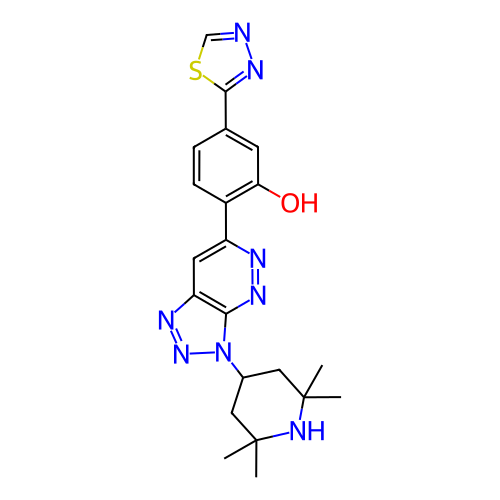

Molecule: CHEMBL4877699 (CHEMBL4877699)


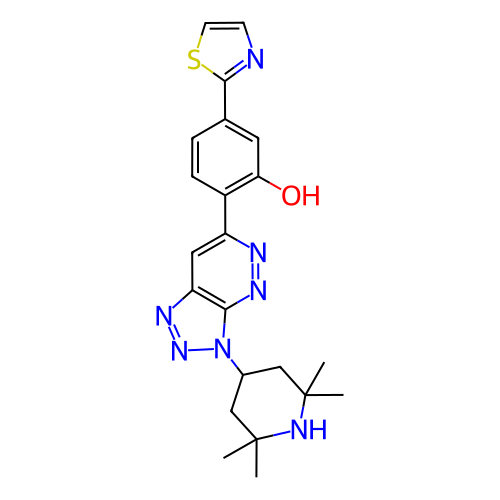

Molecule: CHEMBL4797633 (CHEMBL4797633)


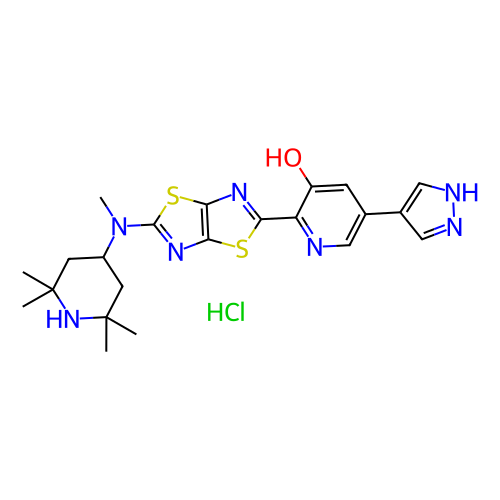

Molecule: CHEMBL4754827 (CHEMBL4754827)


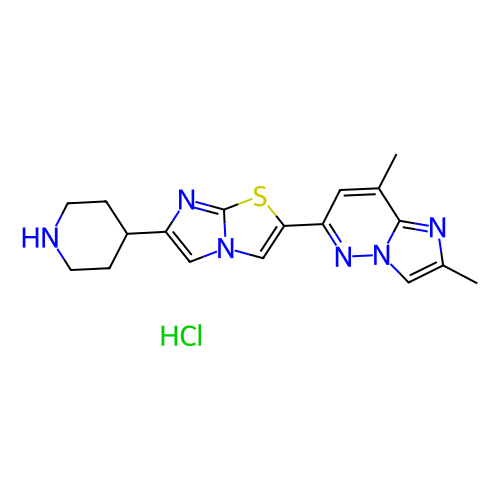

Molecule: CHEMBL4862205 (CHEMBL4862205)


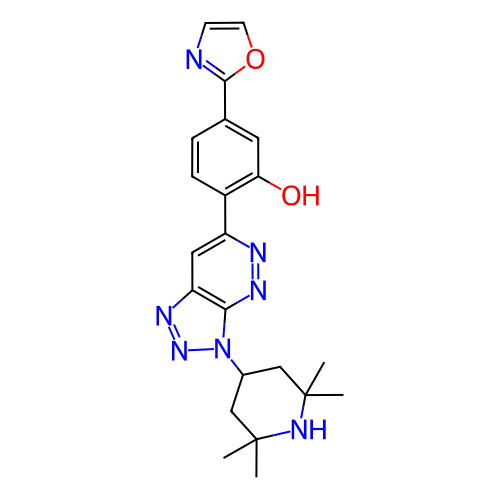

In [27]:
from IPython.display import display, SVG
import pandas as pd

# Display images inline in Jupyter Notebook
for i, row in df.iterrows():
    print(f"Molecule: {row['molLabel']} ({row['molID']})")
    display(SVG(url=row["molImage"]))  # Directly render SVG in Jupyter Notebook


In [29]:
import pandas as pd
from IPython.core.display import display, HTML

# Ensure molImage URLs are correct
df["molImage"] = df["molID"].apply(lambda x: f"https://www.ebi.ac.uk/chembl/api/data/image/{x}.svg" if pd.notnull(x) else "")

# Create an HTML column with embedded images
df["molImage"] = df["molImage"].apply(lambda x: f'<img src="{x}" width="150">' if x else "No Image")

# Select the columns to display
columns_to_display = ["molLabel", "molID", "assayLabel", "assayType", "bindingAffinityType", "value", "molImage"]

# Convert DataFrame to an HTML table
html_table = df[columns_to_display].to_html(escape=False)  # Disable escaping to allow HTML rendering

# Display in Jupyter Notebook
display(HTML(html_table))


,molLabel,molID,assayLabel,assayType,bindingAffinityType,value,molImage
0,CHEMBL5195936,CHEMBL5195936,CHEMBL5129911,Binding,IC50,40.0,
1,CHEMBL5175104,CHEMBL5175104,CHEMBL5129911,Binding,IC50,80.0,
2,CHEMBL5179682,CHEMBL5179682,CHEMBL5129911,Binding,IC50,8.0,
3,CHEMBL4761459,CHEMBL4761459,CHEMBL4714712,Binding,IC50,100.0,
4,CHEMBL442675,CHEMBL442675,CHEMBL1029934,Binding,IC50,10000.0,
5,CHEMBL449571,CHEMBL449571,CHEMBL1029934,Binding,IC50,8130.0,
6,CHEMBL495005,CHEMBL495005,CHEMBL1029934,Binding,IC50,1310.0,
7,CHEMBL4799079,CHEMBL4799079,CHEMBL4714712,Binding,IC50,100.0,
8,CHEMBL4757451,CHEMBL4757451,CHEMBL4714712,Binding,IC50,100.0,
9,CHEMBL4759534,CHEMBL4759534,CHEMBL4714712,Binding,IC50,100.0,


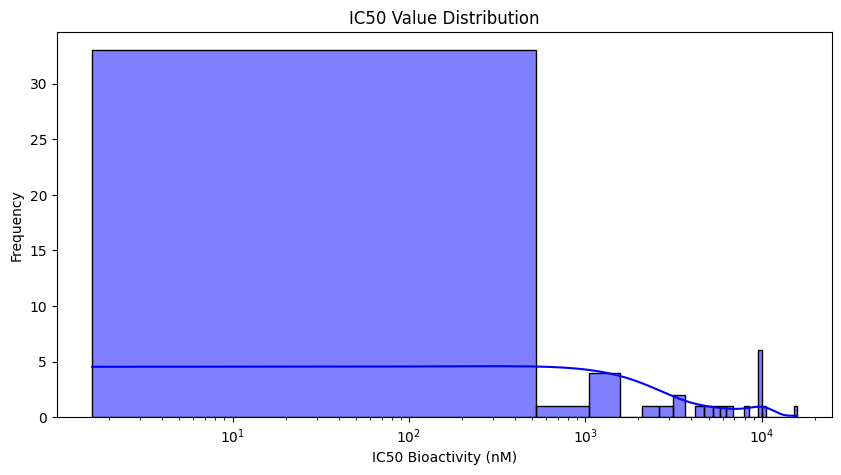

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert 'value' column to numeric
df["value"] = pd.to_numeric(df["value"], errors="coerce")

# Drop missing values
df = df.dropna(subset=["value"])

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(df["value"], bins=30, kde=True, color="blue")

# Log scale for better visualization
plt.xscale("log")
plt.xlabel("IC50 Bioactivity (nM)")
plt.ylabel("Frequency")
plt.title("IC50 Value Distribution")
plt.show()


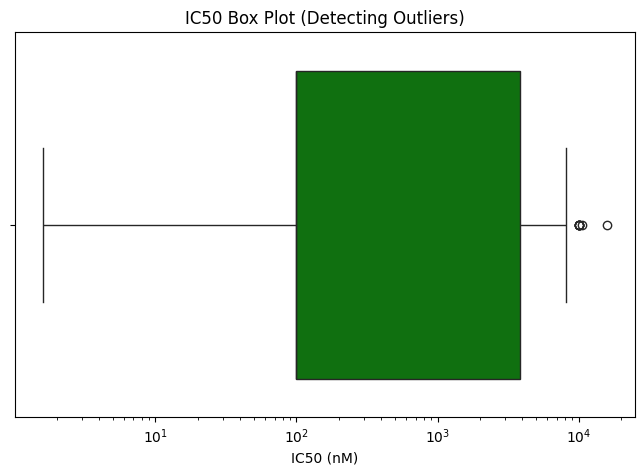

In [32]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["value"], color="green")

# Log scale
plt.xscale("log")
plt.xlabel("IC50 (nM)")
plt.title("IC50 Box Plot (Detecting Outliers)")
plt.show()


In [43]:
# Set the SPARQL query
SPARQL_QUERY_2 = """
PREFIX chembl: <http://rdf.ebi.ac.uk/terms/chembl#>
PREFIX cco: <http://rdf.ebi.ac.uk/terms/chembl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?molLabel ?molID ?targetLabel ?targetID ?assayLabel ?assayID WHERE {
  ?assay chembl:hasTarget ?target.
  ?assay rdfs:label ?assayLabel.
  ?assay chembl:chemblId ?assayID.
  ?activity chembl:hasAssay ?assay.
  ?activity chembl:hasMolecule ?molecule.

  ?molecule rdfs:label ?molLabel.
  ?molecule chembl:chemblId ?molID.

  ?target rdfs:label ?targetLabel.
  ?target chembl:chemblId ?targetID.
} LIMIT 100

"""

df2 = execute_sparql_query(SPARQL_ENDPOINT, SPARQL_QUERY_2)

In [73]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes for Molecules, Targets, and Assays
for _, row in df2.iterrows():
    mol_label = row['molLabel']
    target_label = row['targetLabel']
    assay_label = row['assayLabel']

    # Add molecule node
    G.add_node(mol_label, type='molecule')

    # Add target node
    G.add_node(target_label, type='target')

    # Add assay node
    G.add_node(assay_label, type='assay')

    # Add edges between molecule → assay → target
    G.add_edge(mol_label, assay_label)
    G.add_edge(assay_label, target_label)

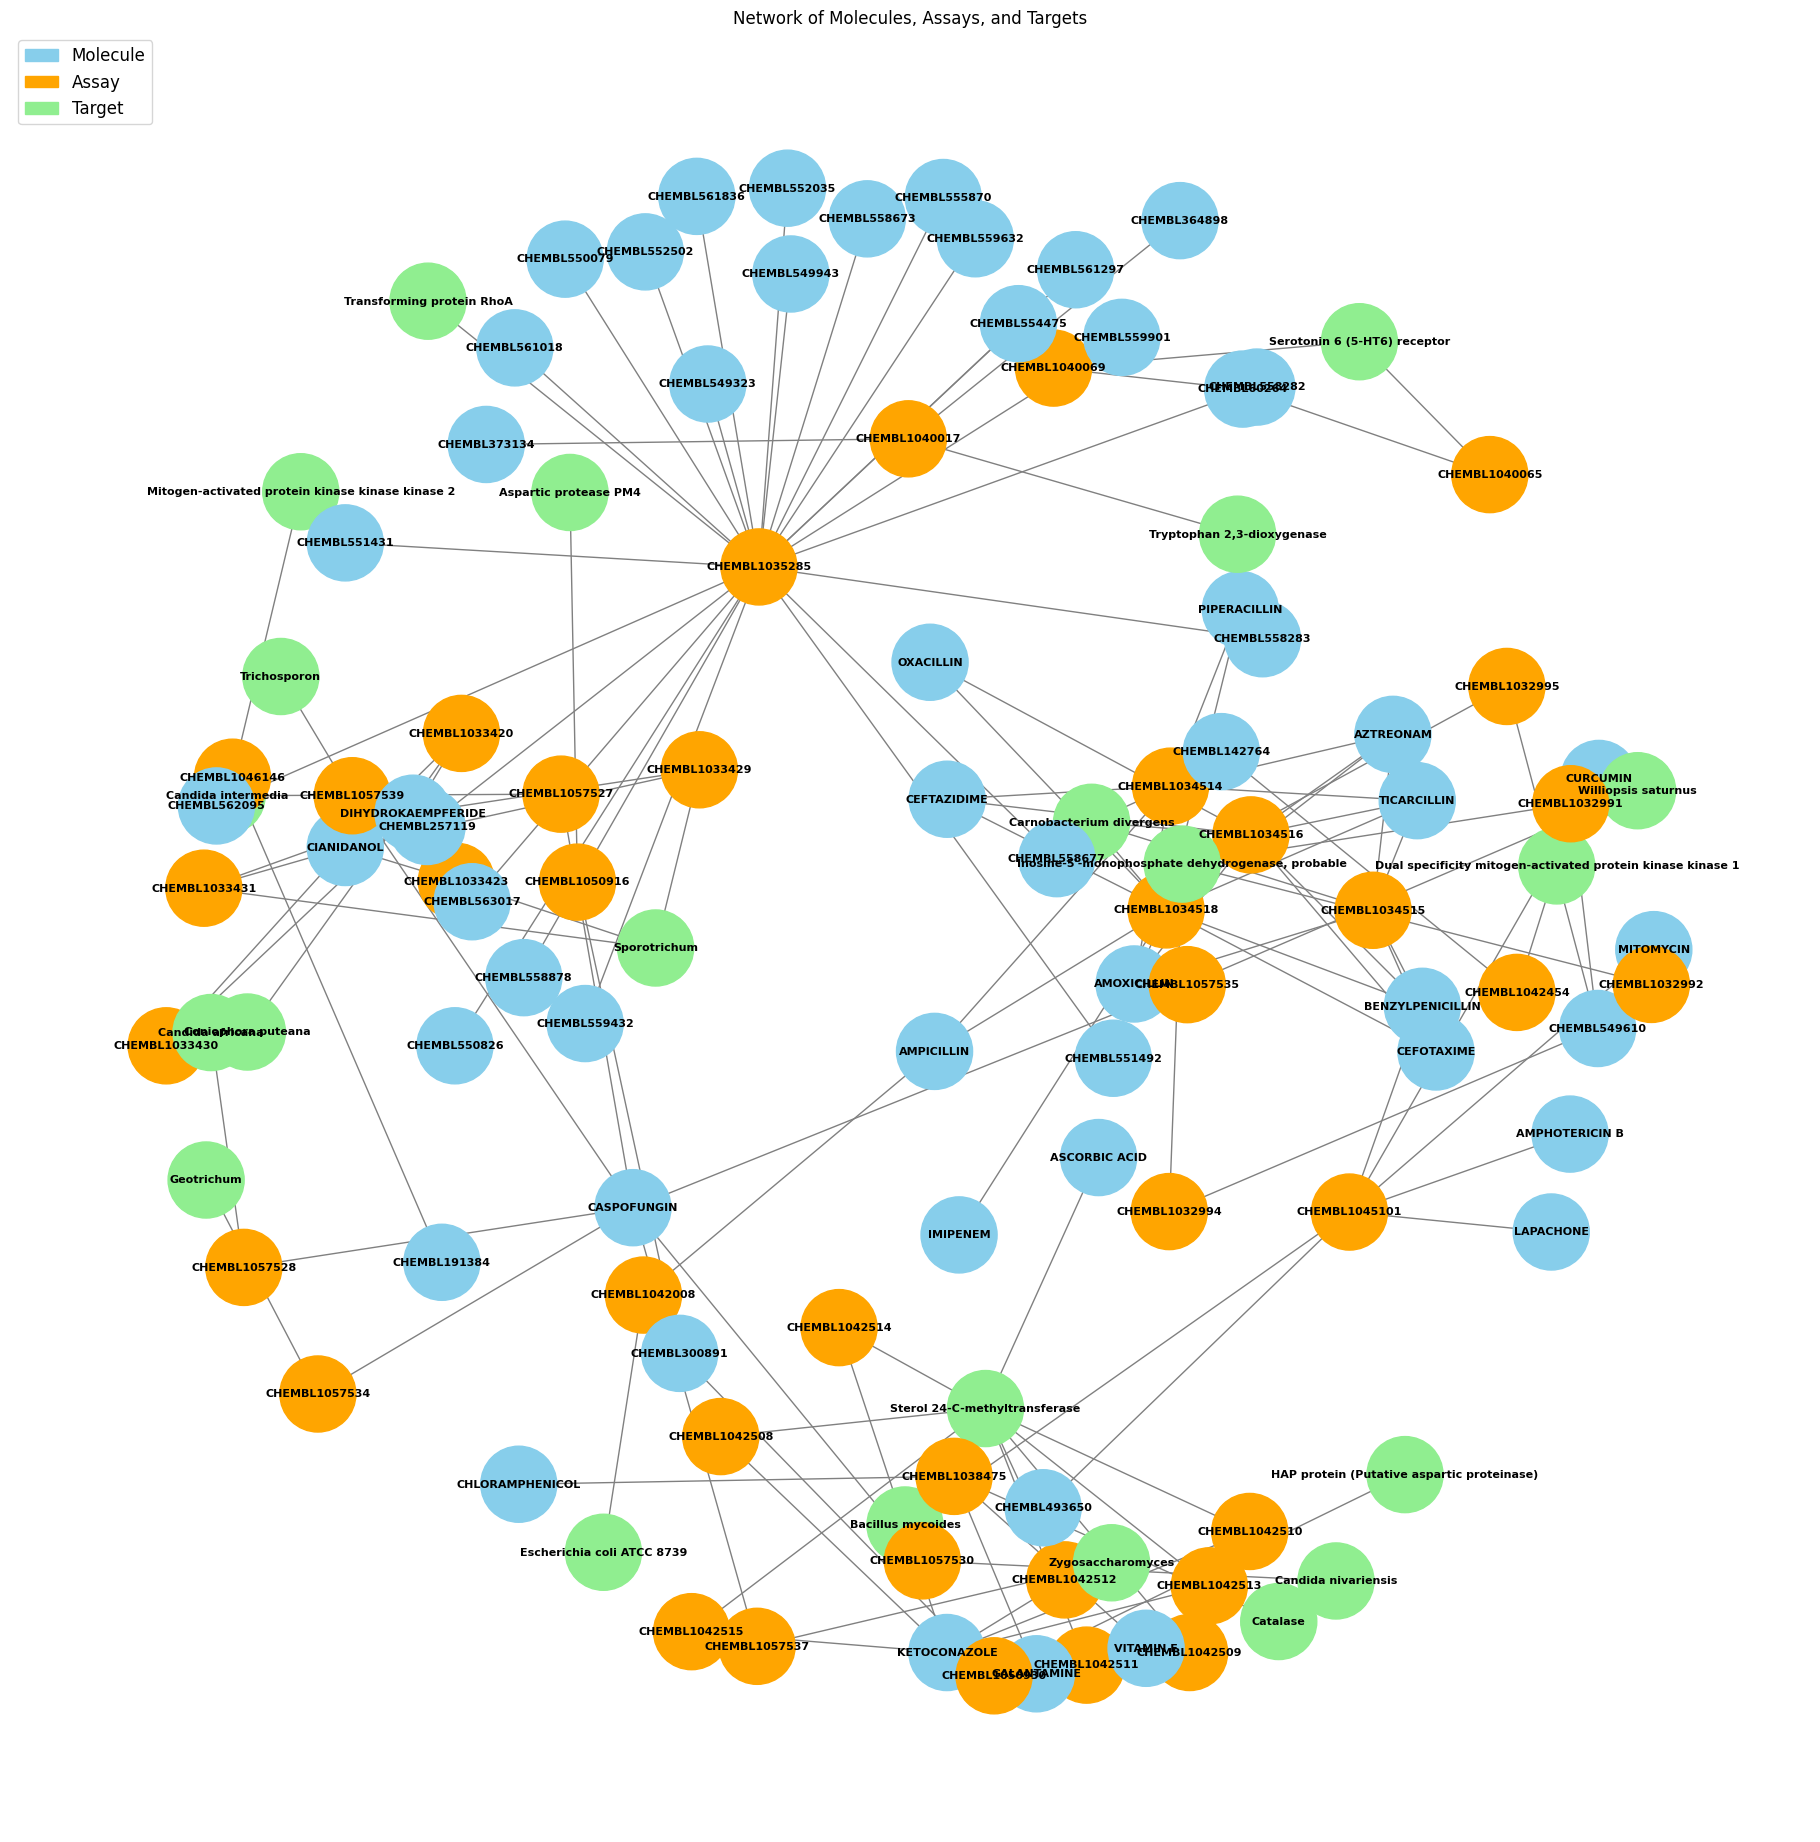

In [75]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

# Define color mapping
node_colors = [G.nodes[node]['type'] for node in G.nodes]
color_map = {"molecule": "skyblue", "assay": "orange", "target": "lightgreen"}
node_color = [color_map[color] for color in node_colors]

# Create the plot
plt.figure(figsize=(18, 18))

# Use spring layout for positioning nodes
pos = nx.spring_layout(G, seed=45, k=0.5)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_color, font_size=8, font_weight="bold", edge_color="gray")

# Add a title to the graph
plt.title("Network of Molecules, Assays, and Targets")

# Create a legend using dummy patches for each node type
molecule_patch = mpatches.Patch(color="skyblue", label="Molecule")
assay_patch = mpatches.Patch(color="orange", label="Assay")
target_patch = mpatches.Patch(color="lightgreen", label="Target")

# Add the legend to the plot
plt.legend(handles=[molecule_patch, assay_patch, target_patch], loc="upper left", fontsize=12)

# Show the plot
plt.show()


In [76]:
import plotly.graph_objects as go

# Create an interactive network using Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_y.append(y0)
    edge_y.append(y1)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

# Define colors for different types of nodes
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=15,
        colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right')
    ),
    text=list(G.nodes())
)

# Create dummy data for the legend
molecule_legend = go.Scatter(
    x=[None], y=[None], mode='markers', marker=dict(color='skyblue', size=15),
    name='Molecule'
)
assay_legend = go.Scatter(
    x=[None], y=[None], mode='markers', marker=dict(color='orange', size=15),
    name='Assay'
)
target_legend = go.Scatter(
    x=[None], y=[None], mode='markers', marker=dict(color='lightgreen', size=15),
    name='Target'
)

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace, molecule_legend, assay_legend, target_legend],
                layout=go.Layout(
                    showlegend=True,  # Show the legend
                    hovermode='closest',
                    title="Network of Molecules, Assays, and Targets",
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False),
                    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
                ))

# Show the plot
fig.show()